### Import all the relevant packages

In [3]:
import numpy as np
from tqdm import tqdm
import cv2
import os
import shutil
import itertools
import imutils
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

import chart_studio.plotly  as py
from chart_studio.plotly import iplot
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from plotly import tools
from PIL import Image
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix

from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.applications.resnet import ResNet50, preprocess_input
from keras.applications.inception_v3 import InceptionV3, preprocess_input


from keras import layers
from keras.models import Model,Sequential
from keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping

## Define useful functions

In [3]:
# def load_data(dir_path, img_size=(100,100)):
#     """
#     Load images as np.arrays to workspace
#     """
#     X = []
#     y = []
#     i = 0
#     labels = dict()
#     for path in tqdm(sorted(os.listdir(dir_path))):
#         if not path.startswith('.'):
#             labels[i] = path
#             for file in os.listdir(dir_path + path):
#                 if not file.startswith('.'):
#                     img = cv2.imread(dir_path + path + '/' + file)
#                     X.append(img)
#                     y.append(i)
#             i += 1
#     X = np.array(X)
#     y = np.array(y)
#     print(f'{len(X)} images loaded from {dir_path} directory.')
#     return X, y, labels



def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.figure(figsize = (6,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    cm = np.round(cm,2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# def plot_samples(X, y, labels_dict, n=50):
#     """
#     Creates a gridplot for desired number of images (n) from the specified set
#     """
#     for index in range(len(labels_dict)):
#         imgs = X[np.argwhere(y == index)][:n]
#         j = 10
#         i = int(n/j)

#         plt.figure(figsize=(15,6))
#         c = 1
#         for img in imgs:
#             plt.subplot(i,j,c)
#             plt.imshow(img[0])

#             plt.xticks([])
#             plt.yticks([])
#             c += 1
#         plt.suptitle('Tumor: {}'.format(labels_dict[index]))
#         plt.show()

# def crop_imgs(set_name, add_pixels_value=0):
#     """
#     Finds the extreme points on the image and crops the rectangular out of them
#     """
#     set_new = []
#     for img in set_name:
#         gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
#         gray = cv2.GaussianBlur(gray, (5, 5), 0)

#         # threshold the image, then perform a series of erosions +
#         # dilations to remove any small regions of noise
#         thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
#         thresh = cv2.erode(thresh, None, iterations=2)
#         thresh = cv2.dilate(thresh, None, iterations=2)

#         # find contours in thresholded image, then grab the largest one
#         cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
#         cnts = imutils.grab_contours(cnts)
#         c = max(cnts, key=cv2.contourArea)

#         # find the extreme points
#         extLeft = tuple(c[c[:, :, 0].argmin()][0])
#         extRight = tuple(c[c[:, :, 0].argmax()][0])
#         extTop = tuple(c[c[:, :, 1].argmin()][0])
#         extBot = tuple(c[c[:, :, 1].argmax()][0])

#         ADD_PIXELS = add_pixels_value
#         new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
#         set_new.append(new_img)

#     return np.array(set_new)


def save_new_images(x_set, y_set, folder_name):
    i = 0
    for (img, imclass) in zip(x_set, y_set):
        if imclass == 0:
            cv2.imwrite(folder_name+'NO/'+str(i)+'.jpg', img)
        else:
            cv2.imwrite(folder_name+'YES/'+str(i)+'.jpg', img)
        i += 1


def preprocess_imgs(set_name, img_size):
    """
    Resize and apply VGG-15 preprocessing
    """
    set_new = []
    for img in set_name:
        img = cv2.resize(
            img,
            dsize=img_size,
            interpolation=cv2.INTER_CUBIC
        )
        set_new.append(preprocess_input(img))
    return np.array(set_new)

## Data Preparation
### This section includes three steps
#### 1. Define the path of images
#### 2. Split the images into train, test, and validate sets
#### 3. Save the splitted images into each folders

In [9]:
RANDOM_SEED = 1234
#For MAC or Linus
IMG_PATH = '/home/jerry/Documents/Program/brain_tumor_dataset/'
dest='/home/jerry/ghworkspace/machine_learning/Final Project/dest/'


#For windows
# IMG_PATH = 'D:\\UCF Coursework\\ML Project\\Program\\brain_tumor_dataset\\'
# dest = 'D:\\UCF Coursework\\ML Project\\Program\\dset\\'model.add(base_model)

In [14]:

## Making Directory
os.mkdir(dest+'TRAIN')
os.mkdir(dest+'TRAIN\\YES')
os.mkdir(dest+'TRAIN\\NO')

os.mkdir(dest+'VAL')
os.mkdir(dest+'VAL\\YES')
os.mkdir(dest+'VAL\\NO')

os.mkdir(dest+'TEST')
os.mkdir(dest+'TEST\\YES')
os.mkdir(dest+'TEST\\NO')

# split the data by train/val/test
for CLASS in os.listdir(IMG_PATH):
    if not CLASS.startswith('.'):
        IMG_NUM = len(os.listdir(IMG_PATH + CLASS))
        for (n, FILE_NAME) in enumerate(os.listdir(IMG_PATH + CLASS)):
            img = IMG_PATH + CLASS + '\\' + FILE_NAME
            if n < 5:
                shutil.copy(img, dest+'TEST\\' + CLASS.upper() + '\\' + FILE_NAME)
            elif n < 0.8*IMG_NUM:
                shutil.copy(img, dest+'TRAIN\\'+ CLASS.upper() + '\\' + FILE_NAME)
            else:
                shutil.copy(img, dest+'VAL\\'+ CLASS.upper() + '\\' + FILE_NAME)




FileExistsError: [Errno 17] File exists: '/home/jerry/Documents/Program/dest/TRAIN'

In [10]:
# For windows
# TRAIN_DIR = dest+'TRAIN\\'
# TEST_DIR =  dest+'TEST\\'
# VAL_DIR =  dest+'VAL\\'

#For MAC or Linux
TRAIN_DIR = dest+'TRAIN/'
TEST_DIR =  dest+'TEST/'
VAL_DIR =  dest+'VAL/'



In [11]:
IMG_SIZE = (224,224) #Size of VGG-16

## Define data augumentation method

### Task 1: Rotation

In [20]:
epochs = 30
batch_size = 60
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    shear_range = 0.1,
    horizontal_flip = True,
    vertical_flip = True,
    preprocessing_function = preprocess_input,
)

test_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
)
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    VAL_DIR,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='binary')
test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='binary')

Found 193 images belonging to 2 classes.
Found 50 images belonging to 2 classes.
Found 10 images belonging to 2 classes.


### Task 2: Zoom

In [94]:
epochs = 30
batch_size = 60
train_datagen = ImageDataGenerator(
    zoom_range=0.5,
)

test_datagen = ImageDataGenerator(
    zoom_range=0.5,
    rotation_range=15,
)
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    VAL_DIR,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='binary')
test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='binary')

Found 193 images belonging to 2 classes.
Found 50 images belonging to 2 classes.
Found 10 images belonging to 2 classes.


### Task 3: Normalization

In [105]:
epochs = 30
batch_size = 60
train_datagen = ImageDataGenerator(
    featurewise_center = True,
    featurewise_std_normalization = True
)

test_datagen = ImageDataGenerator(
    featurewise_center = True,
    featurewise_std_normalization = True,
    rotation_range=15,
)
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    VAL_DIR,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='binary')
test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='binary')

Found 193 images belonging to 2 classes.
Found 50 images belonging to 2 classes.
Found 10 images belonging to 2 classes.


## Define the CNN Model

In [13]:
## Loading the model
base_model = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=IMG_SIZE + (3,)
)

benchmark_1 = ResNet50(
    include_top=True,
    weights="imagenet",
    input_shape=IMG_SIZE + (3,)
)

benchmark_2 = InceptionV3(
    include_top=False,
    weights="imagenet",
    input_shape=IMG_SIZE + (3,)
)

87916544/87910968 [==============================] - 13s 0us/step


In [22]:
NUM_CLASSES = 1


model = Sequential()



model.add(base_model)
# model.add(benchmark_1)
# model.add(benchmark_2)




model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(NUM_CLASSES, activation='sigmoid'))

model.layers[0].trainable = False

model.compile(
    loss='binary_crossentropy',
    optimizer=RMSprop(lr=1e-4),
    metrics=['accuracy']
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 25089     
Total params: 14,739,777
Trainable params: 25,089
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
# history = model.fit_generator(
#     train_generator,
#     steps_per_epoch=193 // batch_size,
#     epochs=epochs,
#     validation_data=validation_generator,
#     verbose = 1
# )

history = model.fit_generator(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    verbose = 1
)

Epoch 1/30
4/4 [==============================] - 16s 4s/step - loss: 10.8407 - accuracy: 0.3806 - val_loss: 108.6589 - val_accuracy: 0.6200
Epoch 2/30
4/4 [==============================] - 16s 4s/step - loss: 10.8001 - accuracy: 0.5518 - val_loss: 58.3006 - val_accuracy: 0.5800
Epoch 3/30
4/4 [==============================] - 17s 4s/step - loss: 5.0420 - accuracy: 0.6269 - val_loss: 21.8366 - val_accuracy: 0.7800
Epoch 4/30
4/4 [==============================] - 20s 5s/step - loss: 3.3833 - accuracy: 0.7339 - val_loss: 7.1319 - val_accuracy: 0.9000
Epoch 5/30
4/4 [==============================] - 20s 5s/step - loss: 3.9203 - accuracy: 0.6734 - val_loss: 9.0113 - val_accuracy: 0.8800
Epoch 6/30
4/4 [==============================] - 21s 5s/step - loss: 1.6423 - accuracy: 0.7864 - val_loss: 83.4299 - val_accuracy: 0.5200
Epoch 7/30
4/4 [==============================] - 20s 5s/step - loss: 4.6075 - accuracy: 0.6131 - val_loss: 13.3122 - val_accuracy: 0.8800
Epoch 8/30
4/4 [==========

In [16]:
history_dict = history.history


### Plotting accuracy loss

In [18]:
## Plotting Accuracy loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

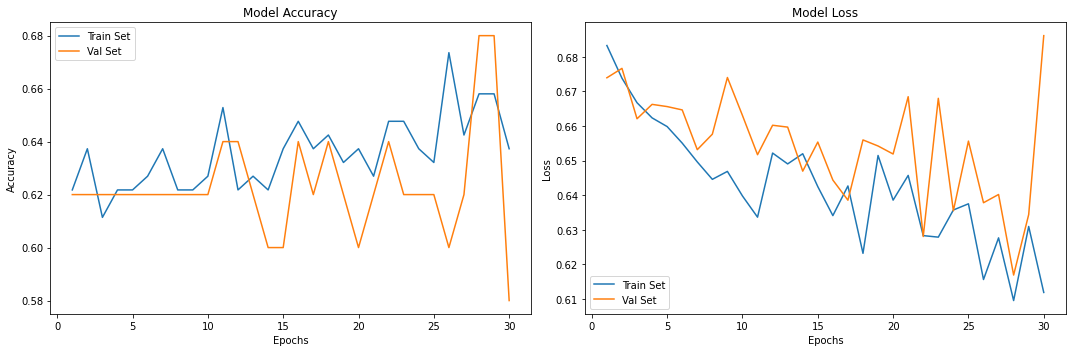

In [19]:
plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

## Validate on val set

In [101]:
labels = {0: 'NO', 1: 'YES'}

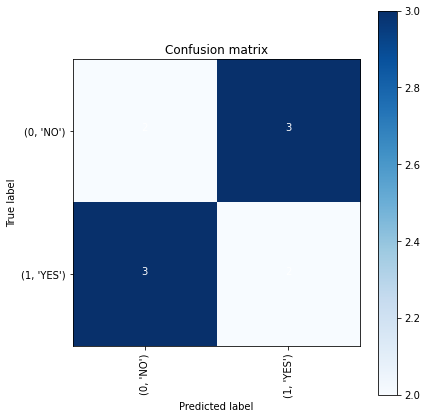

[0 0 0 0 0 1 1 1 1 1]
[[1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]]
[1, 1, 0, 0, 1, 0, 0, 1, 1, 0]


In [102]:

predictions = model.predict(test_generator)
y_pred = [1 if x>0.5 else 0 for x in predictions]

# y_pred = np.argmax(predictions, axis=1)

confusion_mtx = confusion_matrix(test_generator.classes, y_pred)
cm = plot_confusion_matrix(confusion_mtx, classes = list(labels.items()), normalize=False)
print(test_generator.classes)
print(predictions)
print(y_pred)

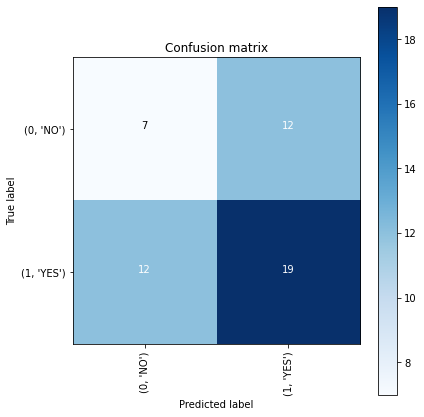

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
[[0.0000000e+00]
 [0.0000000e+00]
 [1.5122158e-19]
 [1.0000000e+00]
 [0.0000000e+00]
 [8.8595385e-17]
 [1.0000000e+00]
 [0.0000000e+00]
 [1.0000000e+00]
 [1.0000000e+00]
 [1.0000000e+00]
 [1.0000000e+00]
 [1.0000000e+00]
 [1.0000000e+00]
 [1.0000000e+00]
 [0.0000000e+00]
 [1.0000000e+00]
 [1.0000000e+00]
 [1.0000000e+00]
 [1.0000000e+00]
 [1.0000000e+00]
 [2.5511923e-24]
 [1.0000000e+00]
 [1.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [1.0000000e+00]
 [1.0000000e+00]
 [0.0000000e+00]
 [1.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [1.0000000e+00]
 [1.0000000e+00]
 [5.8497689e-32]
 [1.0000000e+00]
 [1.0000000e+00]
 [0.0000000e+00]
 [1.0000000e+00]
 [1.0000000e+00]
 [0.0000000e+00]
 [1.0000000e+00]
 [0.0000000e+00]
 [1.0000000e+00]
 [1.0000000e+00]
 [7.8117090e-08]
 [0.0000000e+00]
 [1.0000000e+00]
 [1.0000000e+00]
 [1.0000000e+00]]
[0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 

In [103]:

predictions = model.predict(validation_generator)
y_pred = [1 if x>0.5 else 0 for x in predictions]

# y_pred = np.argmax(predictions, axis=1)

confusion_mtx = confusion_matrix(validation_generator.classes, y_pred)
cm = plot_confusion_matrix(confusion_mtx, classes = list(labels.items()), normalize=False)
print(validation_generator.classes)
print(predictions)
print(y_pred)

In [21]:
car = {
  "brand": "Ford",
  "model": "Mustang",
  "year": 1964
}

x = car.items()

print(list(x))


[('brand', 'Ford'), ('model', 'Mustang'), ('year', 1964)]


In [45]:
test_generator.classes

array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1], dtype=int32)

In [46]:
predictions

[1, 0, 0, 1, 0, 1, 1, 1, 0, 0]